In [1]:
import cv2
import h5py
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from aging.size_norm.data import clean
from aging.organization.dataframes import get_age
from aging.organization.paths import get_experiment_grouped_files
from toolz import compose, valmap, curry, complement, groupby, keyfilter
from aging.plotting import format_plots
warnings.simplefilter('ignore')

In [2]:
format_plots()

In [3]:
paths = get_experiment_grouped_files()

In [4]:
list(paths)

['ontogeny_females',
 'ontogeny_males',
 'dana_ontogeny_males',
 'dana_ontogeny_females',
 'dana_ontogeny_dana_ontogeny',
 'longtogeny_males',
 'longtogeny_v2_males',
 'longtogeny_v2_females',
 'wheel',
 'dlight',
 'jax_longtogeny',
 'klothos']

In [5]:
def is_old_proc(file):
    return file.parent.name == "proc"


def has_key(key, file):
    with h5py.File(file, 'r') as h5f:
        return key in h5f

In [6]:
old_files = valmap(compose(list, curry(filter)(is_old_proc)), paths)
new_files = valmap(compose(list, curry(filter)(complement(is_old_proc))), paths)

In [7]:
def load_frames(file, frames_key='frames', n_frames=1000):
    with h5py.File(file, 'r') as h5f:
        frames = h5f[frames_key][:n_frames]
    return frames

In [8]:
def smooth_clean(frame):
    frame = clean(frame)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [9]:
def fit_pca(frames):
    np.random.seed(0)
    pca = PCA(n_components=10)
    pca.fit(
        np.concatenate(
            [
                v[np.random.permutation(np.arange(len(v)))[:500]]
                for v in frames.values()
            ],
            axis=0,
        ).reshape(-1, (80 * 80))
    )
    return pca


def apply_pca(pca, frames):
    np.random.seed(0)
    x = []
    y = []
    for k, v in frames.items():
        v = v[np.random.permutation(len(v))[:5_000]]
        y.extend([k] * len(v))
        x.append(v)
    x = np.concatenate(x, axis=0)
    x = x.reshape(len(x), -1)
    y = np.array(y)

    pcs = np.concatenate(
        [pca.transform(batch) for batch in np.array_split(x, len(x) // 50_00)], axis=0
    )
    return pcs, y

In [10]:
females = old_files['ontogeny_females']
females = groupby(get_age, females)

males = old_files['ontogeny_males']
males = groupby(get_age, males)

In [11]:
poses = {}
for k, v in tqdm(females.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f))) for f in v[:5]])
    poses[k] = frames

male_poses = {}
for k, v in tqdm(males.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f))) for f in v[:5]])
    male_poses[k] = frames

male_pca = fit_pca(male_poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [12]:
thinning = 5

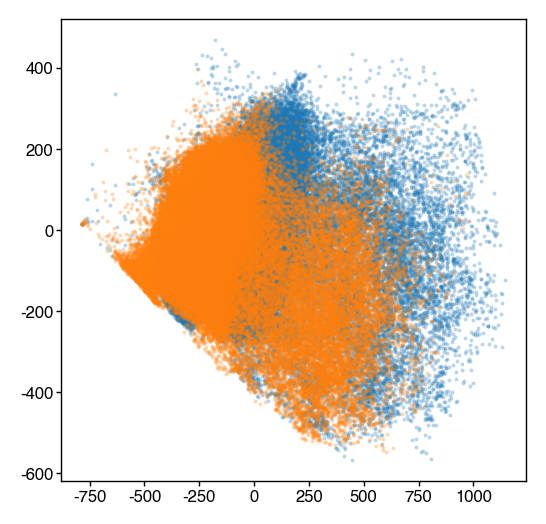

In [13]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

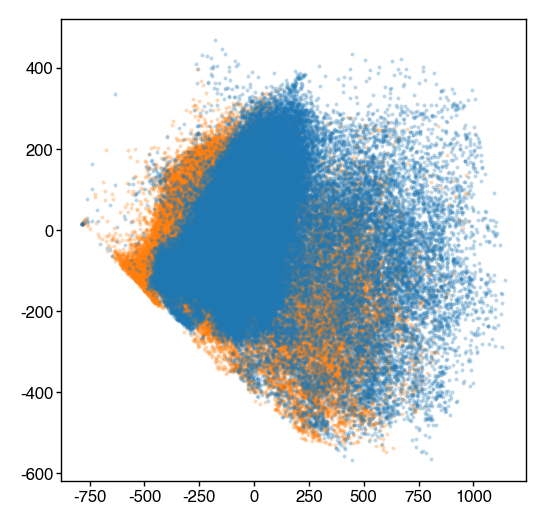

In [14]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

In [15]:
size_norm_k = 'win_size_norm_frames_v7'

In [16]:
filt_females = valmap(compose(list, curry(filter)(curry(has_key)(size_norm_k))), females)
filt_males = valmap(compose(list, curry(filter)(curry(has_key)(size_norm_k))), males)

In [17]:
poses = {}
for k, v in tqdm(filt_females.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        poses[k] = frames

  0%|          | 0/25 [00:00<?, ?it/s]

In [18]:
male_poses = {}
for k, v in tqdm(filt_males.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
    male_poses[k] = frames

  0%|          | 0/23 [00:00<?, ?it/s]

In [19]:
male_pca = fit_pca(male_poses)
# female_pca = fit_pca(poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

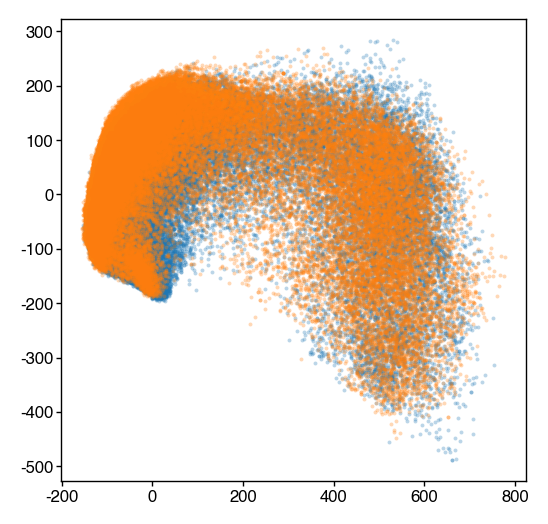

In [20]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

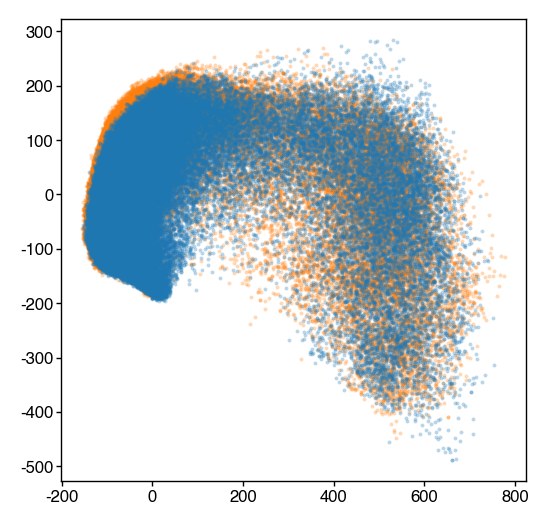

In [21]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

### Only young ages

In [22]:
filt_females = keyfilter(lambda k: k < 40, filt_females)
filt_males = keyfilter(lambda k: k < 40, filt_males)

In [23]:
# size norm
poses = {}
for k, v in tqdm(filt_females.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        poses[k] = frames

male_poses = {}
for k, v in tqdm(filt_males.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        male_poses[k] = frames

male_pca = fit_pca(male_poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

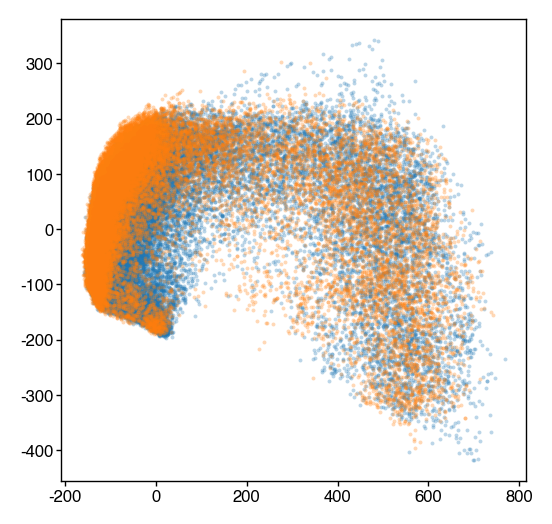

In [24]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

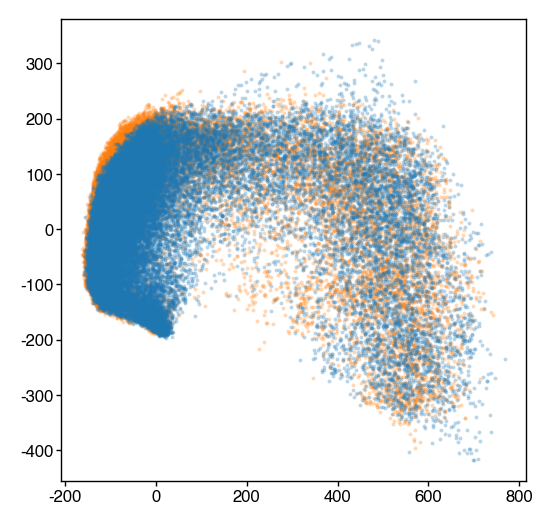

In [25]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

## Longtogeny

In [26]:
females = old_files['longtogeny_v2_females']
females = groupby(lambda k: (get_age(k) // 3) * 3, females)

males = old_files['longtogeny_v2_males']
males = groupby(lambda k: (get_age(k) // 3) * 3, males)

In [27]:
filt_females = valmap(compose(list, curry(filter)(curry(has_key)(size_norm_k))), females)
filt_males = valmap(compose(list, curry(filter)(curry(has_key)(size_norm_k))), males)

In [28]:
poses = {}
for k, v in tqdm(females.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f))) for f in v[:5]])
    poses[k] = frames

male_poses = {}
for k, v in tqdm(males.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f))) for f in v[:5]])
    male_poses[k] = frames

male_pca = fit_pca(male_poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

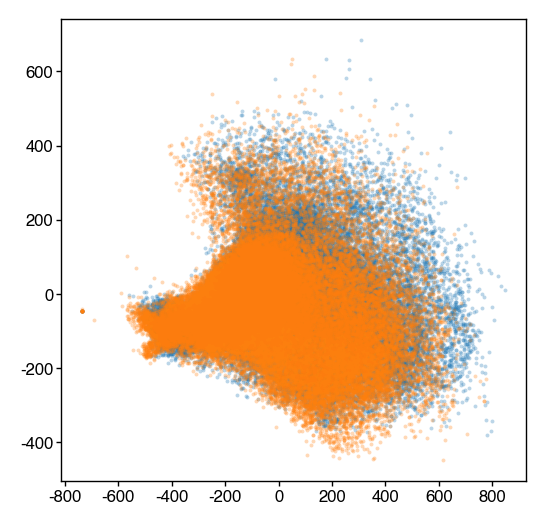

In [29]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

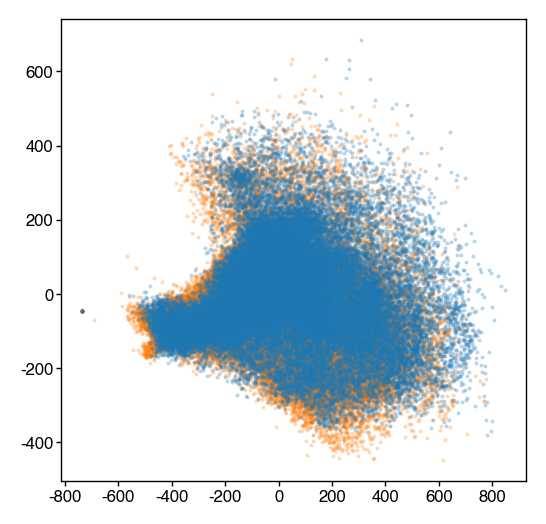

In [30]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

In [31]:
# size norm
poses = {}
for k, v in tqdm(filt_females.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        poses[k] = frames

male_poses = {}
for k, v in tqdm(filt_males.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        male_poses[k] = frames

male_pca = fit_pca(male_poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

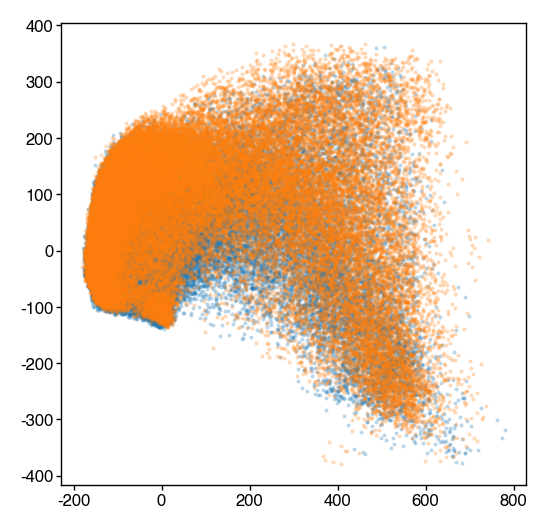

In [32]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

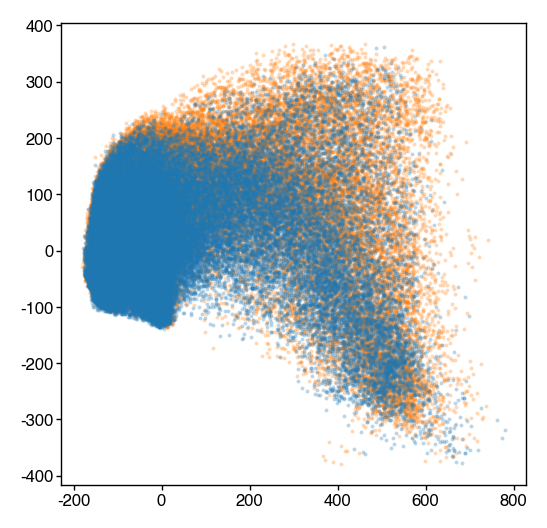

In [33]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

## New extraction

In [34]:
females = new_files['ontogeny_females']
females = groupby(get_age, females)

males = new_files['ontogeny_males']
males = groupby(get_age, males)

In [35]:
poses = {}
for k, v in tqdm(females.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f))) for f in v[:5]])
    poses[k] = frames

male_poses = {}
for k, v in tqdm(males.items()):
    frames = np.vstack([list(map(smooth_clean, load_frames(f))) for f in v[:5]])
    male_poses[k] = frames

male_pca = fit_pca(male_poses)
male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

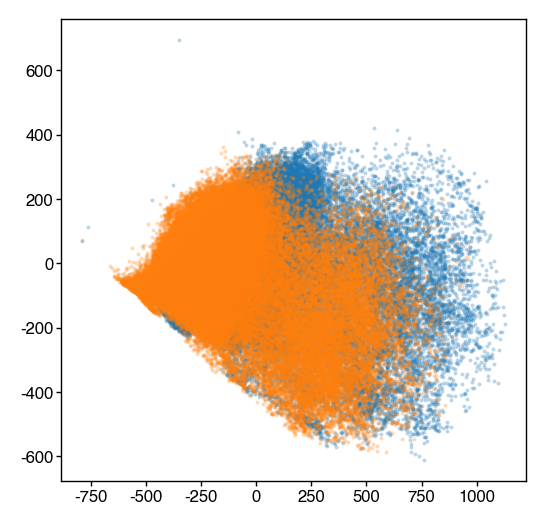

In [36]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

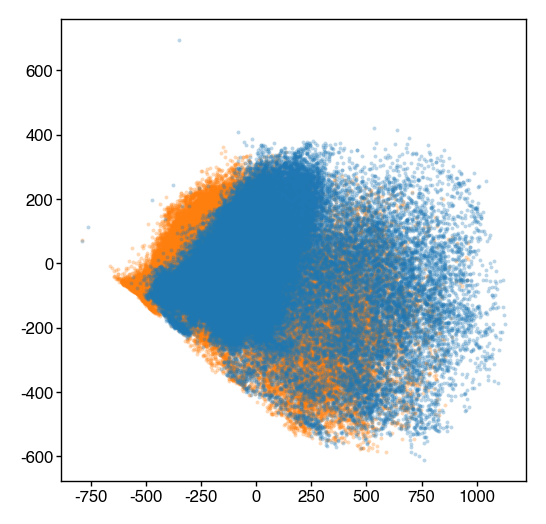

In [37]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

In [38]:
filt_females = valmap(compose(list, curry(filter)(curry(has_key)(size_norm_k))), females)
filt_males = valmap(compose(list, curry(filter)(curry(has_key)(size_norm_k))), males)

In [39]:
# size norm
poses = {}
for k, v in tqdm(filt_females.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        poses[k] = frames

male_poses = {}
for k, v in tqdm(filt_males.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        male_poses[k] = frames

male_pca = fit_pca(male_poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

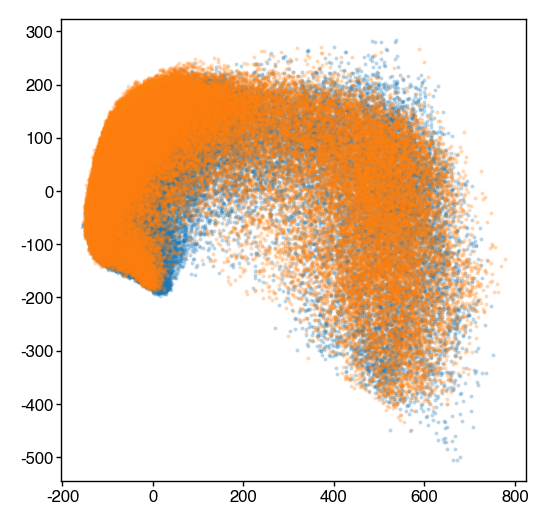

In [40]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

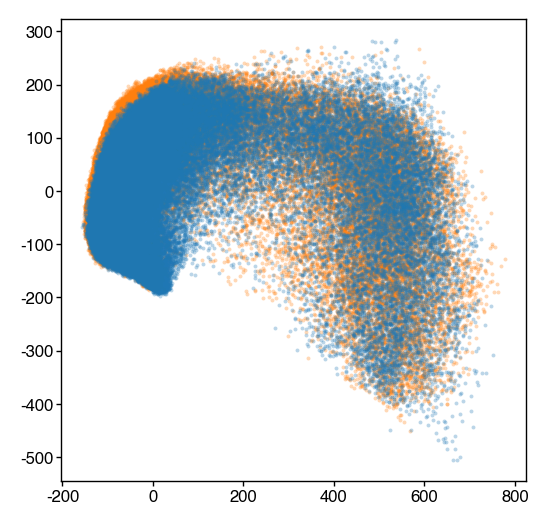

In [41]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)

## Only young ages

In [42]:
filt_females = keyfilter(lambda k: k < 40, filt_females)
filt_males = keyfilter(lambda k: k < 40, filt_males)

In [43]:
# size norm
poses = {}
for k, v in tqdm(filt_females.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        poses[k] = frames

male_poses = {}
for k, v in tqdm(filt_males.items()):
    if len(v) > 0:
        frames = np.vstack([list(map(smooth_clean, load_frames(f, size_norm_k))) for f in v[:5]])
        male_poses[k] = frames

male_pca = fit_pca(male_poses)

male_pcs, male_y = apply_pca(male_pca, male_poses)
female_pcs, female_y = apply_pca(male_pca, poses)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

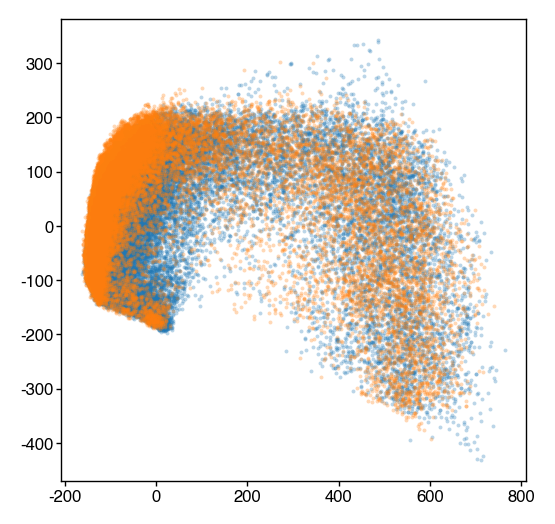

In [44]:
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)

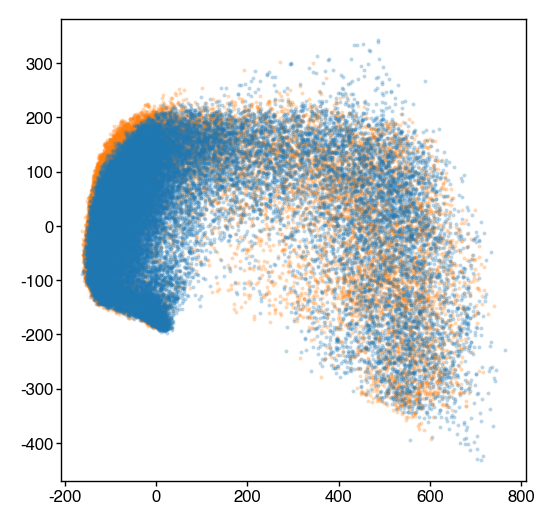

In [45]:
plt.scatter(female_pcs[:, 0], female_pcs[:, 1], c='C1', s=2, alpha=0.3, linewidths=0)
plt.scatter(male_pcs[:, 0], male_pcs[:, 1], c='C0', s=2, alpha=0.3, linewidths=0)